In [17]:
# Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
import pickle
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import collections

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from sklearn.externals import joblib
from lessonFunctions import *


%matplotlib inline


### Load training data from pickle

In [18]:
data = joblib.load('models/svc_01.pkl')
# data = joblib.load('models/clf_9869.pkl')
# svc = data['model']
svc = data['model']
params = data['config']

color_space = params['color_space']
spatial_size = params['spatial_size']
hist_bins = params['hist_bins']
orient = params['orient']
pix_per_cell = params['pix_per_cell']
cell_per_block = params['cell_per_block']
hog_channel = params['hog_channel']
spatial_feat = params['spatial_feat']
hist_feat = params['hist_feat']
hog_feat = params['hog_feat']
X_scaler = params['X_scaler']
print(params)

{'spatial_feat': False, 'hog_channel': 'ALL', 'hist_bins': 32, 'hog_feat': True, 'cell_per_block': 2, 'pix_per_cell': 16, 'color_space': 'YUV', 'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'spatial_size': (32, 32), 'orient': 11, 'hist_feat': False}


## Test sliding window

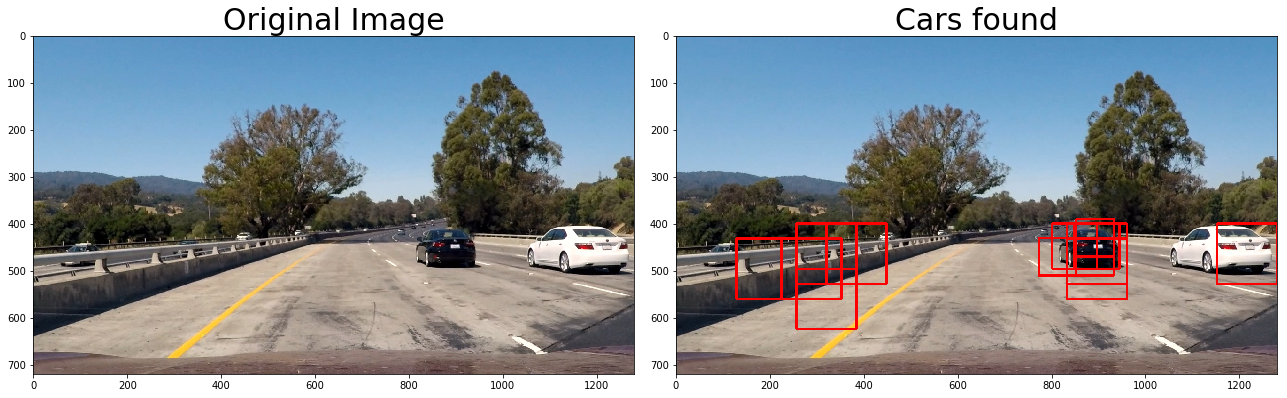

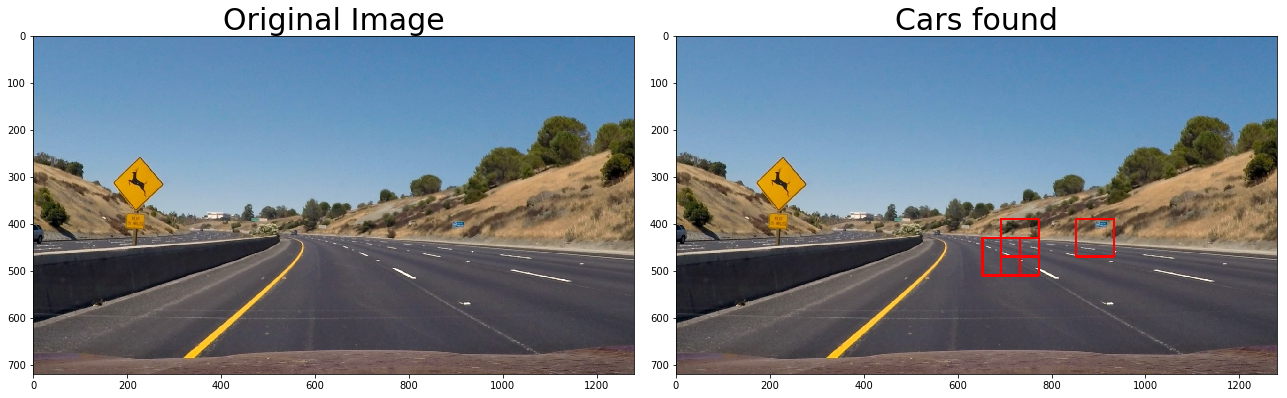

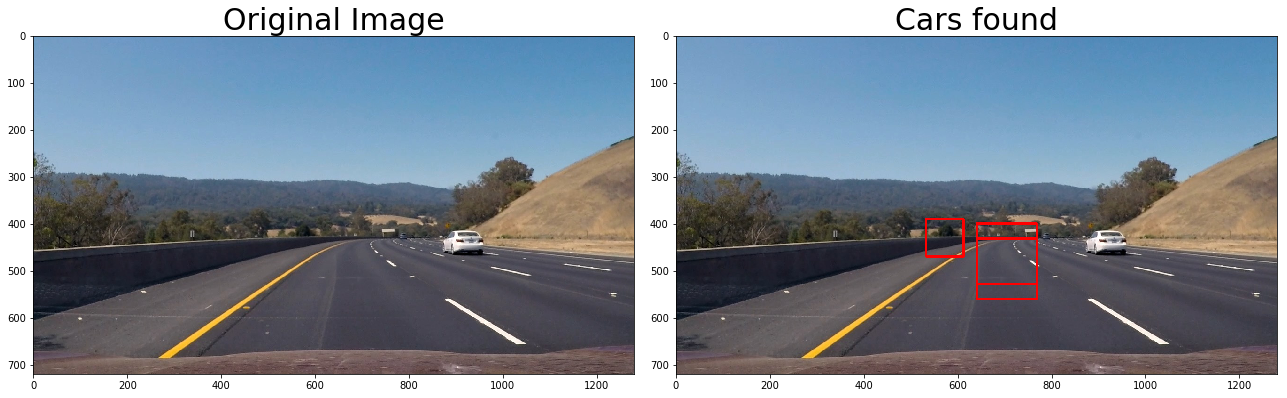

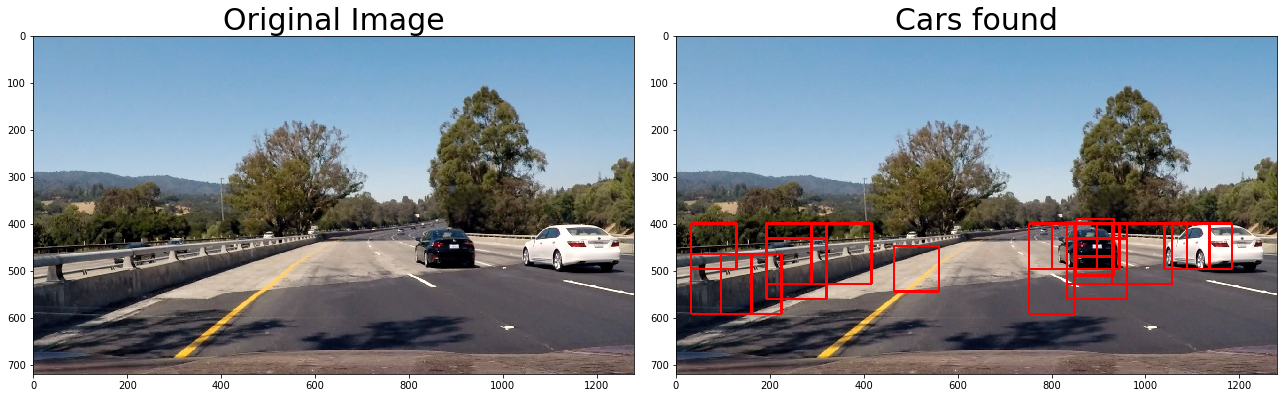

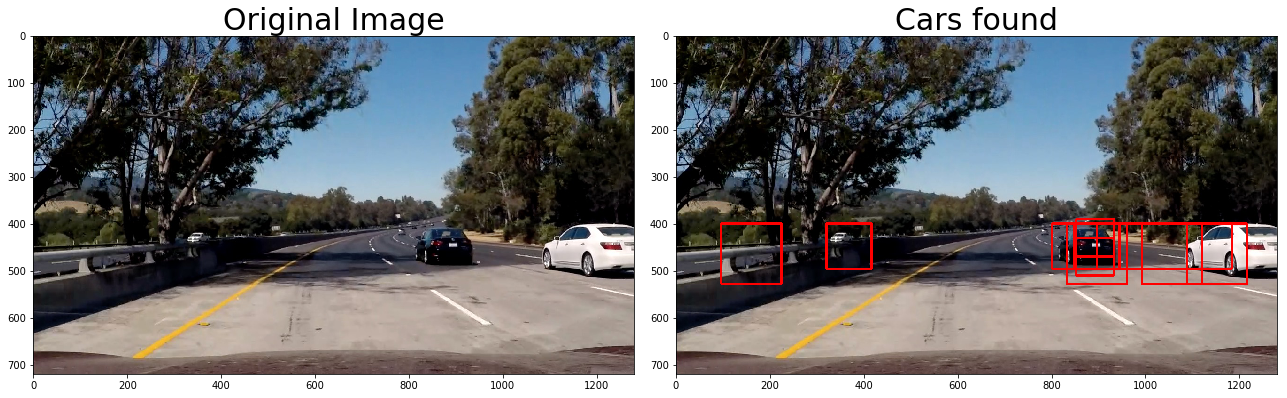

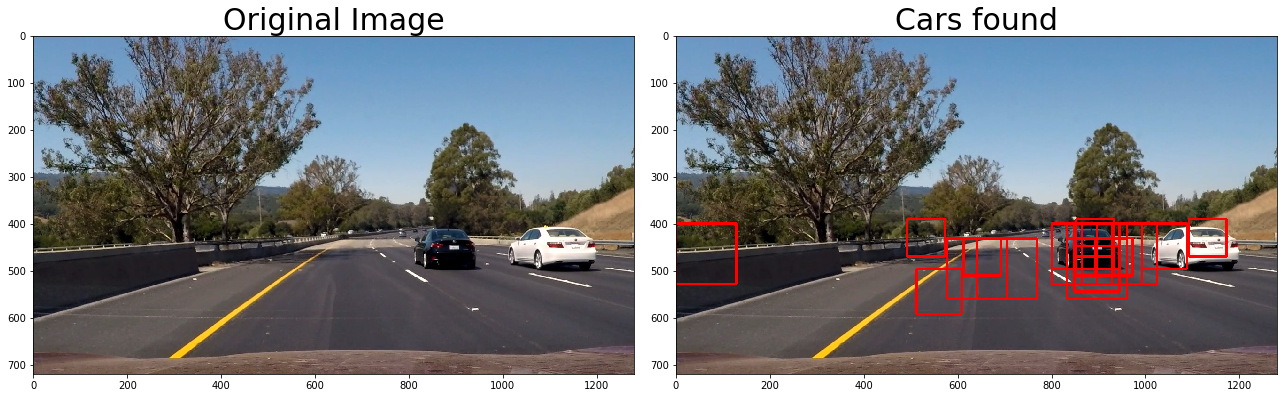

In [19]:

# image = mpimg.imread('test_images/test3.jpg')
# image = test_image.astype(np.float32)/255

# #test5, #test3
# draw_image = np.copy(test_image)


for i in range(1,7):
    
    fname = 'test_images/test{}.jpg'.format(i)
    image = mpimg.imread(fname)
#     Uncomment the following line if you extracted training
#     data from .png images (scaled 0 to 1 by mpimg) and the
#     image you are searching is a .jpg (scaled 0 to 255)
#     image = test_image.astype(np.float32)/255

    draw_image = np.copy(image)


    sw_x_limits = [
        [None, None],
        [None, None],
        [32, None],
        [412, 1280]
    ]

    sw_y_limits = [
        [400, 500],
        [400, 640],
        [400, 600],
        [390, 540]
    ]

    sw_window_size = [
        (144, 144),
        (128, 128),
        (96, 96),
        (80, 80)
    ]

    sw_overlap = [
        (0.75, 0.75),
        (0.75, 0.75),
        (0.5, 0.5),
        (0.5, 0.5)
    ]

    # create sliding windows
    windows = slide_window(image, x_start_stop=sw_x_limits[0], y_start_stop=sw_y_limits[0],
                        xy_window=sw_window_size[0], xy_overlap=sw_overlap[0])

    windows += slide_window(image, x_start_stop=sw_x_limits[1], y_start_stop=sw_y_limits[1],
                        xy_window=sw_window_size[1], xy_overlap=sw_overlap[1])

    windows += slide_window(image, x_start_stop=sw_x_limits[2], y_start_stop=sw_y_limits[2],
                        xy_window=sw_window_size[2], xy_overlap=sw_overlap[2])

    windows += slide_window(image, x_start_stop=sw_x_limits[3], y_start_stop=sw_y_limits[3],
                        xy_window=sw_window_size[3], xy_overlap=sw_overlap[3])


# def process_image(image):
    # plt.imshow(image)
    # windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
    #                     xy_window=(128, 128), xy_overlap=(0.5, 0.5))
#     draw_image = np.copy(image)


    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat) 

    # print(len(windows))

    window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=4) 
#     print(type(window_img))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(draw_image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(window_img)
    ax2.set_title('Cars found', fontsize=30)
    plt.savefig('output_images/sliding_window.png', bbox_inches="tight")
    # plt.imshow(window_img)
    plt.show()
    
#     return window_img

# window_img = process_image(image)
    
# plt.imshow(window_img)
# plt.show()


## Find cars function

In [21]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
 # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'GRAY':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2GRAY)
            print(ctrans_tosearch.shape)
        elif cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
#             print(ctrans_tosearch.shape)
    else: ctrans_tosearch = np.copy(image)   
       
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]
        

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rectangles =[] #https://github.com/jeremy-shannon/CarND-Vehicle-Detection/blob/master/vehicle_detection_project.ipynb
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

#             # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
#             # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
# #             spatial_features = np.array(spatial_features)
# #             img_features.append(spatial_features)
            
# #             print("spatial: ", spatial_features.shape, "type: ", type(spatial_features))

#             hist_features = color_hist(subimg, nbins=hist_bins)
# #             hist_features = np.array(hist_features)
# #             img_features.append(hist_features)
            
# #             print("hist: ", hist_features.shape, "type: ", type(hist_features))

#             # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))   
# #             test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))   

            test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))
    
# #             test_features = X_scaler.transform(np.hstack((hog_feat1)).reshape(1, -1))    

#             #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
#             print(test_prediction)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),6) 
                rectangles.append(((xbox_left, ytop_draw+ystart), #github.com/preritj
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

# img = mpimg.imread('./test_images/test5.jpg')

    
# ystart = 400
# ystop = 600
# scale = 1.5
    
# out_img = find_cars(img, ystart, ystop, scale, svc, Xscaler, orient, pix_per_cell, cell_per_block, spatialSize, histBins)

# plt.imshow(out_img)

In [ ]:
triangle = [((64, 64),  [400, 500]),
           ((96, 96),  [400, 500]),
           ((128, 128),[450, 578]),
           ((192, 192),[450, None]),
      ]
image_size = (720, 1280)
windows = create_windows(triangle, image_size)

## Heatmaps tests with example images

39
59
137
115
128


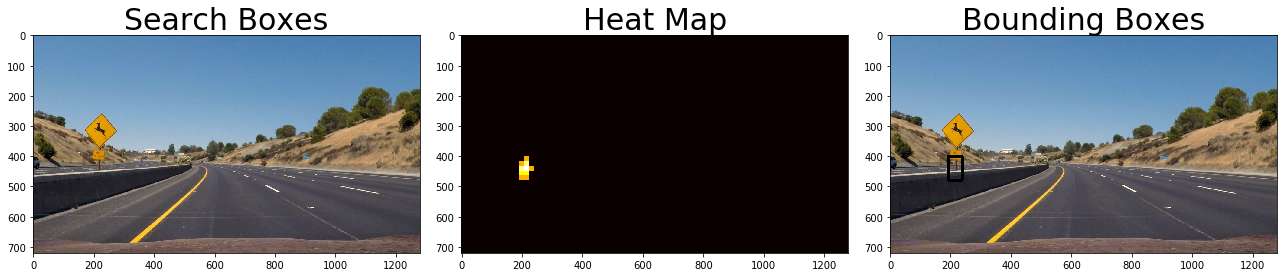

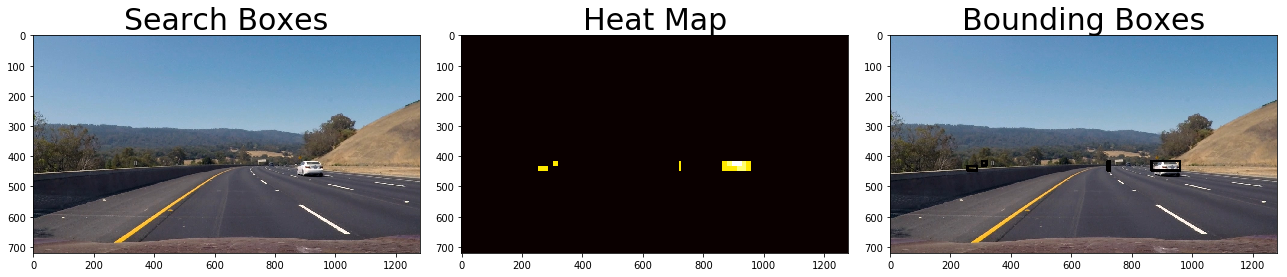

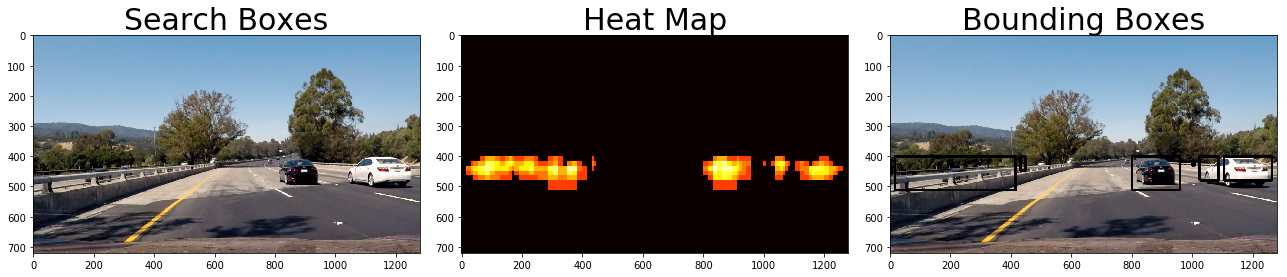

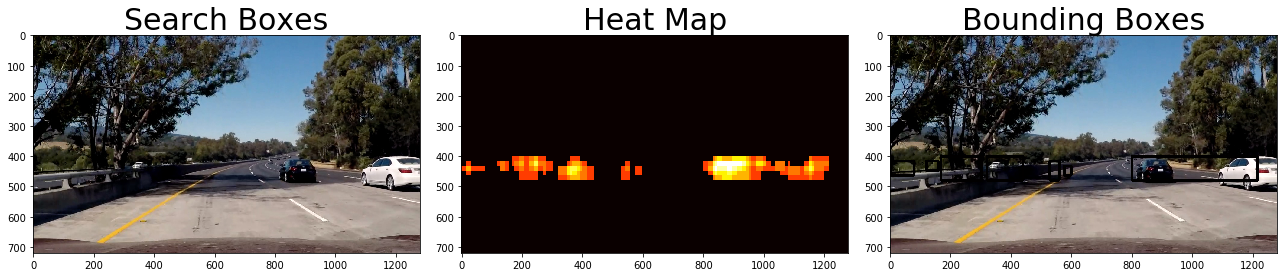

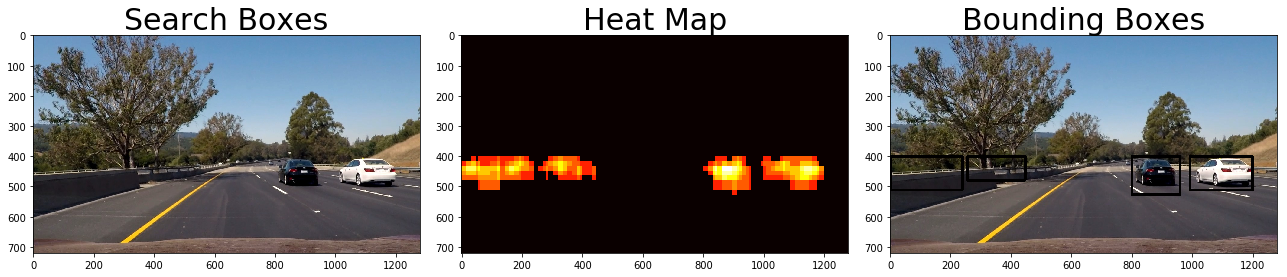

In [24]:
from scipy.ndimage.measurements import label

for i in range(2,7):

    fname = 'test_images/test{}.jpg'.format(i)
    img = mpimg.imread(fname)
    img = img.astype(np.float32)/255

#     img = mpimg.imread('./test_images/test3.jpg')    

#     orient=10
#     pix_per_cell=8
#     cell_per_block=2
#     spatial_size=(32, 32)
#     hist_bins=64

    bbox_list = []


    ystart = 400
    ystop = 464
    scale = 0.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))
    
    ystart = 416
    ystop = 480
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))

    ystart = 400
    ystop = 496
    scale = 1.25
    bbox_list.append(find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))

    ystart = 432
    ystop = 528
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))
    
    ystart = 400
    ystop = 528
    scale = 1.75
    bbox_list.append(find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))
    
    ystart = 400
    ystop = 528
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))
    
    ystart = 432
    ystop = 560
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))
    
    ystart = 400
    ystop = 596
    scale = 3.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))
    
    ystart = 464
    ystop = 660
    scale = 3.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))
  
  

    bbox_list = [item for sublist in bbox_list for item in sublist] 

    print(len(bbox_list))
    
#     out_img = draw_boxes(img, bbox_list, color=(255, 0, 0), thick=4)

    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,4)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Search Boxes', fontsize=30)
    ax2.imshow(heat, cmap='hot')
    ax2.set_title('Heat Map', fontsize=30)
    ax3.imshow(draw_img)
    ax3.set_title('Bounding Boxes', fontsize=30)
    plt.savefig('output_images/heat_map1.png', bbox_inches="tight")

In [11]:
# Borrowed from 
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

print('...')

...


## Function to process video with

In [12]:
def process_frame(img):
    
    bbox_list = []


    ystart = 400
    ystop = 464
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, Xscaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))
    
    ystart = 416
    ystop = 480
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, Xscaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))

    ystart = 400
    ystop = 496
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, Xscaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))

    ystart = 432
    ystop = 528
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, Xscaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))
    
    ystart = 400
    ystop = 528
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, Xscaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))
    
    ystart = 400
    ystop = 528
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, Xscaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))
    
    ystart = 432
    ystop = 560
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, Xscaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))
    
    ystart = 400
    ystop = 596
    scale = 3.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, Xscaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))
    
    ystart = 464
    ystop = 660
    scale = 3.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, Xscaler,
                                    orient, pix_per_cell, cell_per_block,
                                    None, None))
    
    # apparently this is the best way to flatten a list of lists

    bbox_list = [item for sublist in bbox_list for item in sublist] 

#     print(len(bbox_list))
    
#     out_img = draw_boxes(img, bbox_list, color=(255, 0, 0), thick=4)

#     if len(bbox_list) > 0:
#         det.add_rects(bbox_list)
   

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
#     for rect_set in det.prev_rects:
#     heat = add_heat(heat, rect_set)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,6)
    heatmaps.append(heat)
    heatmapSum = sum(heatmaps)


#     heat = apply_threshold(heat,1 + len(det.prev_rects)//2)

#     # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmapSum, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
#     print(labels[1], 'cars found')
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img
    
print('...')

...


In [140]:
# det = Vehicle_Detect()
heatmaps = collections.deque(maxlen=10) 

t = time.time()

test_out_file = 'test_video_out.mp4'
# clip_test = VideoFileClip('test_video.mp4')
# clip_test = VideoFileClip('project_video.mp4').subclip(5, 50)
clip_test = VideoFileClip('project_video.mp4')

clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

t2 = time.time()
print(round(t2 - t, 5), 'Seconds to process video.')



[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4



 24%|██▍       | 303/1261 [05:27<17:47,  1.11s/it]


 48%|████▊     | 605/1261 [10:36<12:28,  1.14s/it]


 72%|███████▏  | 907/1261 [15:45<05:41,  1.04it/s]


 96%|█████████▌| 1205/1261 [20:34<00:53,  1.05it/s]


100%|█████████▉| 1260/1261 [21:27<00:00,  1.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 37min 6s, sys: 3.39 s, total: 37min 9s
Wall time: 21min 27s
1289.29497 Seconds to process video.
